##### Reference
- https://github.com/keon/3-min-pytorch/blob/master/09-%EA%B2%BD%EC%9F%81%ED%95%98%EB%A9%B0_%ED%95%99%EC%8A%B5%ED%95%98%EB%8A%94_GAN/gan.ipynb
- https://m.blog.naver.com/PostView.nhn?blogId=stop2y&logNo=221529660467&proxyReferer=https:%2F%2Fwww.google.com%2F

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
EPOCHS=3
BATCH_SIZE=100
USE_CUDA=torch.cuda.is_available()
DEVICE=torch.device('cuda' if USE_CUDA else 'cpu')
print('Using Device:',DEVICE)

Using Device: cpu


In [3]:
#Fashion MNIST 데이터셋
train_dataset=datasets.FashionMNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5),(0.5))
    ])
)
train_loader=torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


생성자: 64차원의 랜덤한 텐서를 입력받아 행렬곱(Linear)과 활성화 함수(ReLU,Tanh)연산 실행
결과: 생성자의 결과값 784차원

In [6]:
#생성자(Generator)
G=nn.Sequential(
    nn.Linear(64,256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256,784),
    nn.Tanh()
)


판별자: 784차원의 텐서를 입력받는다.
- 생성자와 달리 판별자의 결과값은 입력받은 텐서가 진짜인지 구분하는 예측값

In [7]:
# 판별자(Discriminator)
D=nn.Sequential(
    nn.Linear(784,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,1),
    nn.Sigmoid())

In [8]:
#모델의 가중치를 지정한 장치로 전송
D=D.to(DEVICE)
G=G.to(DEVICE)

#이진 크로스 엔트로피 (Binary cross entropy) 오차 함수와 생성자와 판별자를 최적화할 Adam 모듈
criterion=nn.BCELoss()
g_optimizer=optim.Adam(G.parameters(), lr=0.0002)
d_optimizer=optim.Adam(D.parameters(),lr=0.0002)

In [9]:
total_step=len(train_loader)
for epoch in range(EPOCHS):
    for i, (images,_) in enumerate(train_loader):
        images=images.reshape(BATCH_SIZE,-1).to(DEVICE)
        # '진짜'와 '가짜' 레이블 생성
        real_labels=torch.ones(BATCH_SIZE,1).to(DEVICE)
        fake_labels=torch.ones(BATCH_SIZE,1).to(DEVICE)

        #판별자가 진짜 이미지를 진짜로 인식하는 오차를 계산
        outputs=D(images)
        d_loss_real=criterion(outputs,real_labels)
        real_score=outputs
        
        # 무작위 텐서로 가짜 이미지를 생성
        z=torch.randn(BATCH_SIZE,64).to(DEVICE)
        fake_images=G(z)

        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs=D(fake_images)
        d_loss_fake=criterion(outputs,fake_labels)
        fake_score=outputs

        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss=d_loss_real+d_loss_fake

        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        #생성자가 판별자를 속였는지에 대한 오차를 계산
        fake_images=G(z)
        outputs=D(fake_images)
        g_loss=criterion(outputs,real_labels)

        #역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    #학습 진행 상태    
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))


Epoch [0/3], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [1/3], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [2/3], d_loss: 0.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 1.00


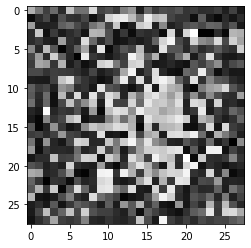

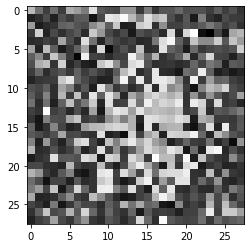

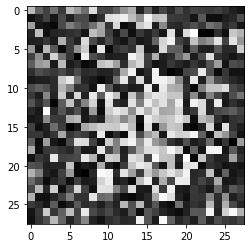

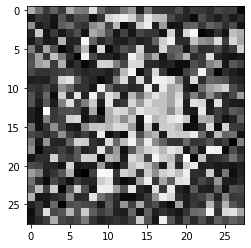

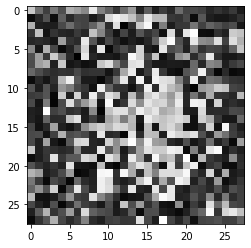

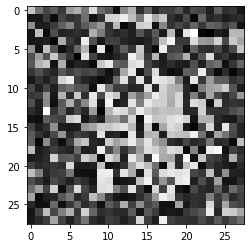

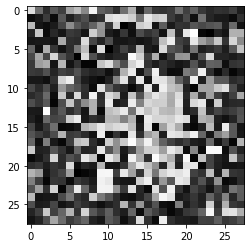

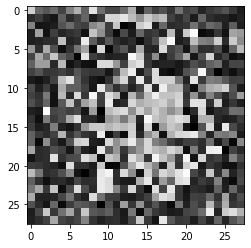

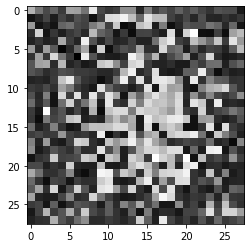

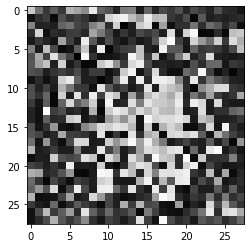

In [11]:
#학습이 끝난 생성자의 결과물 확인
z=torch.randn(BATCH_SIZE,64).to(DEVICE)
fake_images=G(z)
for i in range(10):
  fake_images_img=np.reshape(fake_images.data.cpu().numpy()[i],(28,28))
  plt.imshow(fake_images_img,cmap='gray')
  plt.show()